# Reading STAR/MRCS files -- comparison with CryoJAX

In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from simplecryoem.utils import *
from simplecryoem.projection import project_spatial, project, rotate_z0
from simplecryoem.interpolate import *
from simplecryoem.emfiles import load_data
import jax

from project import project as project_pyem
from pyem import star
from pyem import vop
import mrcfile

from external.cryojax.JEM3 import api01 as jem3api01
plt.rcParams["figure.figsize"]=8,8



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'cryojax'

### The files

In [3]:
#data_dir =  "/gpfs/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_roy10k.star"

data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"

### Cryojax

In [4]:
rawdat = jem3api01.raw_images_class()
rawdat.starloader(data_dir,star_file, threads=4)

read_star_mrcs: load star


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


read_star_mrcs: sort star
read_star_mrcs: group star by mrc file
read_star_mrcs: number of particles: 39972
read_star_mrcs: Computed size is 0.831000 A
read_star_mrcs: grouping particles by output stack
read_star_mrcs: convert parameters time:  31.448949098587036
read_star_mrcs: reading images... 
read_star_mrcs: read images time:  81.00307083129883
read_star_mrcs: compute fft2...
read_star_mrcs: fft time:  41.42079305648804
read_star_mrcs: images_array.shape: (39972, 308, 308)
read_star_mrcs: len(images_array): 39972
raw_images_class: starloader: full frequency radius (a.k.a. Nyquist): 0.597777673589948


### My code

In [5]:
imgs_f, params = load_data(data_dir, star_file)

pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]
ctf_params = params["ctf_params"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


load_data: number of partcles:  39972
load_data: data loaded, time:  28.548207759857178
load_data: FFT of data, time:  108.71003437042236


### Compare the data

#### Dimensions

In [6]:
print(imgs_f.shape)
print(rawdat.images_fft.shape)

(39972, 308, 308)
(39972, 308, 308)


#### Angles 

Note that I modified cryojax slightly to output the angles in addition to the rotation matrix.

In [8]:
angles_rev = [ang[::-1] for ang in angles]
ma = angles_rev- rawdat.images_var['a']
assert(np.sum(np.abs(ma)) == 0)

#### Shifts

In [9]:
assert(np.sum(np.abs(rawdat.images_var['organgst'] - shifts)) == 0)

#### CTF parameters

In [10]:
print(ctf_params.shape)
print(rawdat.images_var['ctf'].shape)

(39972, 9)
(39972, 8)


In [11]:
assert(np.sum(np.abs(ctf_params[:,:8] - rawdat.images_var['ctf'])) == 0.0)

#### Pixel size

In [12]:
rawdat.image_sstep

0.831

In [13]:
assert(np.sum(pixel_size-rawdat.image_sstep) == 0)

#### The actual images

For some reason they don't fit exactly - probably because of the FFTW differences, it seems like
the CryoJAX images are truncated to about 4 digits

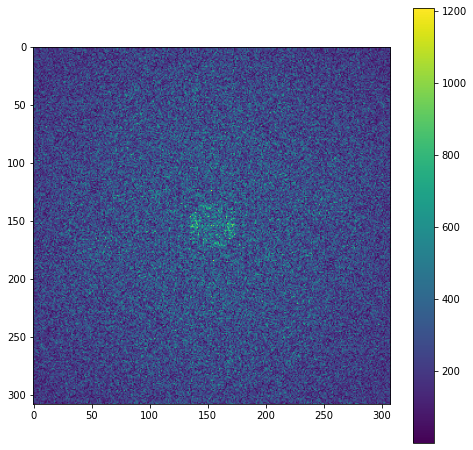

In [14]:
idx = 100
plt.imshow(np.fft.fftshift(np.abs(imgs_f[idx]))); plt.colorbar()

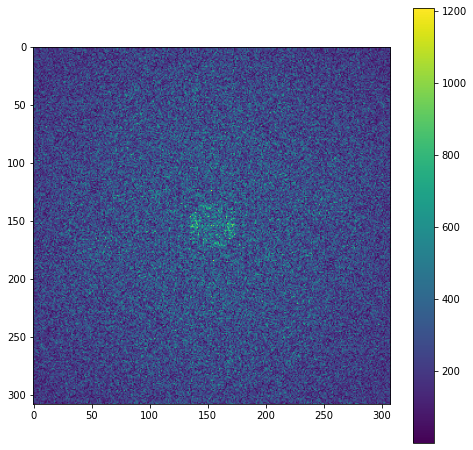

In [15]:
plt.imshow(np.fft.fftshift(np.abs(rawdat.images_fft[idx]))); plt.colorbar()

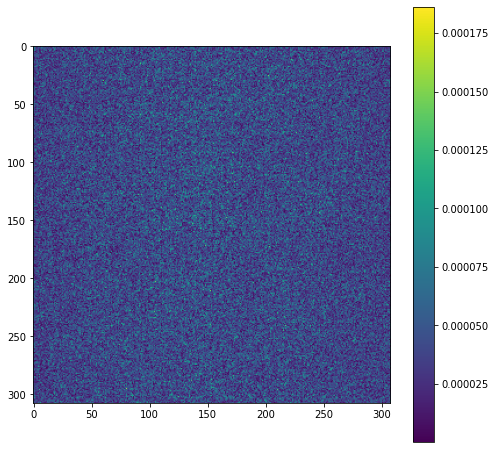

In [16]:
plt.imshow(np.fft.fftshift(np.abs(imgs_f[idx]- rawdat.images_fft[idx]))); plt.colorbar()

In [17]:
print(np.max(np.abs(imgs_f)))
print(np.max(np.abs(rawdat.images_fft)))
print(np.max(np.abs(imgs_f - rawdat.images_fft)))

8909.065568494158
8909.065
0.0009638056981791256
